In [1]:
# Imports
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import torch as torch
from torch import nn
from nltk.tokenize import word_tokenize
import math as mt
import time
import random
from joblib import Parallel, delayed
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import shuffle
import helper
print("Done")

Done


# Task 2.1: Training Classifier model on Hindi data

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    
#Reading hindi data and shuffling it
#data_development contains complete data, labels contain the output
url = 'data/hindi_hatespeech.tsv'
data = pd.read_csv(url, sep='\t')
data_development = shuffle(data)

labels = data_development['task_2']
# data_development = data
# type(data_development['task_1'])

print("Done", device)

Done cpu


In [3]:
#Applying stopwords removal
sentences = helper.apply_stopword_removal(data_development)
print("Number of sentences: " , len(sentences))

#Building Vocabulary
V, non_unique = helper.build_vocabulary(sentences) #V is unique words, non_unique is the total words
print('Total words:', len(non_unique))
print('Unique words:', len(V))

Number of sentences:  4665
Total words: 141550
Unique words: 19836


In [4]:
#Load Word2Vec embeddings module
weights1, weights2 = helper.load_word2vec_embeddings('model_param_finalised', device, len(V), 600)
print(weights1.shape, weights2.shape)

Word2Vec(
  (fc1): Linear(in_features=19836, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=19836, bias=True)
)
torch.Size([19837, 600]) torch.Size([600, 19836])


## Create Dataset

In [5]:
## create number array of sentences (replace each word its each numeric value)
x_data, max_len_curr = helper.sentence_to_numeric_arr(sentences, V)

## apply padding
padded = np.array(helper.padding(x_data, max_len_curr))

print("data shape after padding: ", padded.shape)

#Encoding the labels to 0 and 1. 0 = not hate speech , 1 = hate speech
encoded_labels = [0 if label == "NONE" else 1 for label in labels]
encoded_labels = np.array(encoded_labels)
print("Labels shape after encoding: ", encoded_labels.shape)

(4665, 132)
(4665,)


In [6]:
#split data into train & test set

batch_size = 64
train_loader, test_loader = helper.split_data_train_valid_test(padded, encoded_labels, batch_size)
print("Done")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Done


In [10]:
#Initialize LSTM model 
net, criterion= helper.initialize_SentimentLSTM_model(len(V) + 1, 600, 32, 1, 2, device, weights1)

print(net)

SentimentLSTM(
  (embedding): Embedding(19837, 600)
  (lstm): LSTM(600, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Training

<ipython-input-11-3edcb967e788>:20: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/200 Training Loss: 0.6921
Epoch: 2/200 Training Loss: 0.6751
Epoch: 3/200 Training Loss: 0.6651
Epoch: 4/200 Training Loss: 0.6605
Epoch: 5/200 Training Loss: 0.6528
Epoch: 6/200 Training Loss: 0.6445
Epoch: 7/200 Training Loss: 0.6368
Epoch: 8/200 Training Loss: 0.6261
Epoch: 9/200 Training Loss: 0.6088
Epoch: 10/200 Training Loss: 0.5946
Epoch: 11/200 Training Loss: 0.5736
Epoch: 12/200 Training Loss: 0.5723
Epoch: 13/200 Training Loss: 0.5550
Epoch: 14/200 Training Loss: 0.5453
Epoch: 15/200 Training Loss: 0.5352
Epoch: 16/200 Training Loss: 0.5443
Epoch: 17/200 Training Loss: 0.5308
Epoch: 18/200 Training Loss: 0.5299
Epoch: 19/200 Training Loss: 0.5171
Epoch: 20/200 Training Loss: 0.5117
Epoch: 21/200 Training Loss: 0.4965
Epoch: 22/200 Training Loss: 0.5031
Epoch: 23/200 Training Loss: 0.4871
Epoch: 24/200 Training Loss: 0.5003
Epoch: 25/200 Training Loss: 0.4791
Epoch: 26/200 Training Loss: 0.4908
Epoch: 27/200 Training Loss: 0.4796
Epoch: 28/200 Training Loss: 0.4820
E

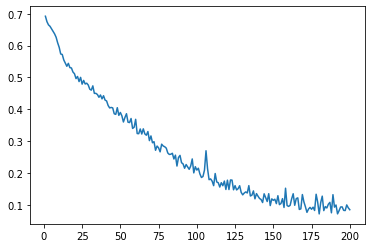

In [11]:
##Perform Training

optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, amsgrad=True)
print_every = 100
step = 0
n_epochs = 200  
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN

training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
#         if (step % print_every) == 0:            
#             ######################
#             ##### VALIDATION #####
#             ######################
#             net.eval()
#             valid_losses = []
#             v_h = net.init_hidden(batch_size, device)
            
#             for v_inputs, v_labels in valid_loader:
#                 v_inputs, v_labels = inputs.to(device), labels.to(device)
        
#                 v_h = tuple([each.data for each in v_h])
                
#                 v_output, v_h = net(v_inputs, batch_size)
#                 v_loss = criterion(v_output.squeeze(), v_labels.float())
#                 valid_losses.append(v_loss.item())

#             print("Epoch: {}/{}".format((epoch+1), n_epochs),
#                   "Step: {}".format(step),
#                   "Training Loss: {:.4f}".format(loss.item()),
#                   "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
#         net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
plt.savefig('Task2_hindi.png')
print("Done")

## Testing

In [12]:
## Perform Testing to calculate test accuracy
net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.6302
Test Accuracy: 0.68


# Task 2.2: Testing Bengali Data on Hindi Classifier

In [24]:
#Reading Bengali data
bengali_data, labels = helper.get_bengali_data('data/bengali_hatespeech.csv')
# print(bengali_data)
print(bengali_data.shape, labels.shape)

(4665, 3) (4665,)


In [25]:
## Stopwords Removal of Bengali Data
bengali_sentences = helper.apply_stopword_removal(bengali_data)
print("Number of sentences: " , len(bengali_sentences))

## Building Vocabulary
bengali_V, bengali_non_unique = helper.build_vocabulary(bengali_sentences)
print('Total words:', len(bengali_non_unique))
print('Unique words:', len(bengali_V))

## Sentence to numeric array
x_data_bengali, max_len_curr = helper.sentence_to_numeric_arr(bengali_sentences, bengali_V)

## Apply Padding
padded = np.array(helper.padding(x_data_bengali, max_len_curr))
print(padded.shape)

Number of sentences:  4665
Total words: 64027
Unique words: 14482
(4665, 402)


In [26]:
#create test data to pass to the model
test_data = TensorDataset(torch.tensor(padded), torch.tensor(labels))
batch_size = 64
train_loader, test_loader = helper.split_data_train_valid_test(padded, labels, 64)
net, criterion= helper.initialize_SentimentLSTM_model_bengali(len(V) + 1, 600, 32, 1, 2, device, weights1)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Task 2.3: Transfer Learning

<ipython-input-27-e5af900be1ba>:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/20 Training Loss: 0.6723
Epoch: 2/20 Training Loss: 0.3671
Epoch: 3/20 Training Loss: 0.1457
Epoch: 4/20 Training Loss: 0.0811
Epoch: 5/20 Training Loss: 0.0504
Epoch: 6/20 Training Loss: 0.0400
Epoch: 7/20 Training Loss: 0.0297
Epoch: 8/20 Training Loss: 0.0279
Epoch: 9/20 Training Loss: 0.0261
Epoch: 10/20 Training Loss: 0.0142
Epoch: 11/20 Training Loss: 0.0110
Epoch: 12/20 Training Loss: 0.0114
Epoch: 13/20 Training Loss: 0.0075
Epoch: 14/20 Training Loss: 0.0064
Epoch: 15/20 Training Loss: 0.0069
Epoch: 16/20 Training Loss: 0.0083
Epoch: 17/20 Training Loss: 0.0063
Epoch: 18/20 Training Loss: 0.0061
Epoch: 19/20 Training Loss: 0.0044
Epoch: 20/20 Training Loss: 0.0049
Done


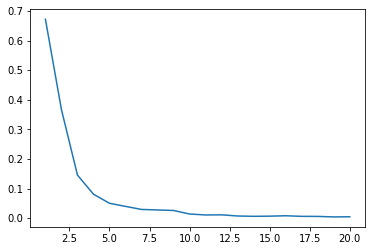

In [27]:
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, amsgrad=True)
print_every = 100
step = 0
n_epochs = 20  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN

training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
#         print(i, inputs.shape, labels.shape)
        # making requires_grad = False for the latest set of h
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
#         if (step % print_every) == 0:            
#             ######################
#             ##### VALIDATION #####
#             ######################
#             net.eval()
#             valid_losses = []
#             v_h = net.init_hidden(batch_size, device)
            
#             for v_inputs, v_labels in valid_loader:
#                 v_inputs, v_labels = inputs.to(device), labels.to(device)
        
#                 v_h = tuple([each.data for each in v_h])
                
#                 v_output, v_h = net(v_inputs, batch_size)
#                 v_loss = criterion(v_output.squeeze(), v_labels.float())
#                 valid_losses.append(v_loss.item())

#             print("Epoch: {}/{}".format((epoch+1), n_epochs),
#                   "Step: {}".format(step),
#                   "Training Loss: {:.4f}".format(loss.item()),
#                   "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
#             net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
plt.savefig('Task2_transferlearning.png')    
print("Done")

In [28]:
net.eval()

test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.4029
Test Accuracy: 0.75


# Task 2.4: Training classifier on Bengali embeddings

In [29]:
#Load Word2Vec embeddings module
weights1, weights2 = helper.load_word2vec_embeddings('model_param_finalised_bengali', device, len(bengali_V), 600)
print(weights1.shape, weights2.shape)

Word2Vec(
  (fc1): Linear(in_features=14482, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=14482, bias=True)
)
torch.Size([14483, 600]) torch.Size([600, 14482])


In [30]:
#split data into train, valid & test set
# labels = labels.cpu().detach().numpy()
print(padded.shape, labels.shape)
print(type(padded), type(labels))

print("Done")

(4665, 402) torch.Size([64])
<class 'numpy.ndarray'> <class 'torch.Tensor'>
Done


In [33]:
net, criterion = helper.initialize_SentimentLSTM_model(len(bengali_V) + 1, 600, 32, 1, 2, device, weights1)

print(net)

SentimentLSTM(
  (embedding): Embedding(14483, 600)
  (lstm): LSTM(600, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


<ipython-input-34-695c0798ed93>:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/100 Training Loss: 0.6918
Epoch: 2/100 Training Loss: 0.6561
Epoch: 3/100 Training Loss: 0.5558
Epoch: 4/100 Training Loss: 0.4858
Epoch: 5/100 Training Loss: 0.4253
Epoch: 6/100 Training Loss: 0.3611
Epoch: 7/100 Training Loss: 0.3189
Epoch: 8/100 Training Loss: 0.2693
Epoch: 9/100 Training Loss: 0.2363
Epoch: 10/100 Training Loss: 0.2115
Epoch: 11/100 Training Loss: 0.1874
Epoch: 12/100 Training Loss: 0.1635
Epoch: 13/100 Training Loss: 0.1399
Epoch: 14/100 Training Loss: 0.1333
Epoch: 15/100 Training Loss: 0.1198
Epoch: 16/100 Training Loss: 0.1087
Epoch: 17/100 Training Loss: 0.1037
Epoch: 18/100 Training Loss: 0.0968
Epoch: 19/100 Training Loss: 0.0816
Epoch: 20/100 Training Loss: 0.0785
Epoch: 21/100 Training Loss: 0.0752
Epoch: 22/100 Training Loss: 0.0780
Epoch: 23/100 Training Loss: 0.0797
Epoch: 24/100 Training Loss: 0.0765
Epoch: 25/100 Training Loss: 0.0732
Epoch: 26/100 Training Loss: 0.0632
Epoch: 27/100 Training Loss: 0.5698
Epoch: 28/100 Training Loss: 0.1202
E

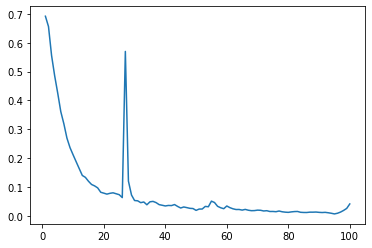

In [34]:
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, amsgrad=True)
print_every = 100
step = 0
n_epochs = 100  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN
# device = 'cuda' if torch.cuda.is_available() else 'cpu'


training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
#         if (step % print_every) == 0:            
#             ######################
#             ##### VALIDATION #####
#             ######################
#             net.eval()
#             valid_losses = []
#             v_h = net.init_hidden(batch_size, device)
            
#             for v_inputs, v_labels in valid_loader:
#                 v_inputs, v_labels = inputs.to(device), labels.to(device)
        
#                 v_h = tuple([each.data for each in v_h])
                
#                 v_output, v_h = net(v_inputs, batch_size)
#                 v_loss = criterion(v_output.squeeze(), v_labels.float())
#                 valid_losses.append(v_loss.item())

#             print("Epoch: {}/{}".format((epoch+1), n_epochs),
#                   "Step: {}".format(step),
#                   "Training Loss: {:.4f}".format(loss.item()),
#                   "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
#             net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
plt.savefig('Task2_bengali.png')   
print("Done")

In [35]:
# import os 
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    
    
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.5457
Test Accuracy: 0.73
